In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import the MNIST dataset
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

from torchdiffeq import odeint_adjoint

# Training Auto Encoder on generalized dataset of balls

In [2]:
def create_random_dataset(r_max, n_samples, size, conv=False):
    data = []
    for i in range(n_samples):
        r = np.random.randint(r_max)
        image = np.zeros((size, size), dtype=np.uint8)
        x = np.random.randint(low=1, high=size, size=(2))
        image = cv2.circle(image, (x[0], x[1]), r, 255, -1)/255.
        if conv:
            image = np.expand_dims(image, axis=0)
        data.append([image, np.array([x[0]/size, x[1]/size, r/r_max]) ] )

    return data

samples = create_random_dataset(4, 300, 28, conv=True)

In [3]:
class custom_loss(nn.Module):
    def __init__(self, image_loss=nn.BCELoss(), factor=0.5):
        super(custom_loss, self).__init__()
        self.image_loss = image_loss
        self.factor = factor

    def forward(self, true_image, image, true_position, position):
        # print((1-self.factor)*self.image_loss(true_image, image))
        # print(self.factor*torch.mean(torch.sum((true_position - position)**2, dim=1)))
        return (1-self.factor)*self.image_loss(true_image, image) + self.factor*torch.mean(torch.sum((true_position - position)**2, dim=1))

loss_fn = custom_loss(nn.MSELoss(), 0.5)

In [4]:
def train(model, dataloader_train, dataloader_test, optimizer, criterion, epochs=10, display_step=1):
    
    iterator = trange(epochs)
    losses_train = []
    losses_test = []
    for _ in iterator:
        loss_epoch = 0
        model.train()
        for i, data in enumerate(dataloader_train):
            image, position = data
            image = image.float()
            position = position.float()
            optimizer.zero_grad()
            output, position_pred = model(image)
            loss = criterion(image.squeeze(), output.squeeze(), position, position_pred)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            if i % display_step == 0:
                iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
            

        losses_train.append(loss_epoch/len(dataloader_train))
        model.eval()
        with torch.no_grad():
            loss_epoch = 0
            for i, data in enumerate(dataloader_test):
                image, position = data
                image = image.float()
                position = position.float()    
                output, position_pred = model(image)
                loss = criterion(image.squeeze(), output.squeeze(), position, position_pred)
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')
            
            losses_test.append(loss_epoch/len(dataloader_test))

    return losses_train, losses_test

In [5]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Linear(in_features=self.height*self.width, out_features=64),
                    nn.ReLU(),
                    nn.Linear(in_features=64, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=64),
                    nn.ReLU(),
                    nn.Linear(in_features=64, out_features=self.height*self.width),
                    nn.Sigmoid()
        )

        print("Parameters number: ", sum([p.numel() for p in self.parameters()]))
        

    def forward(self, features):
        out = self.flatten(features)
        positions = self.encoder(out)
        out = self.decoder(positions)
        reconstructed = out.view(features.shape[0], self.height, self.width)
        return reconstructed, positions

In [7]:
class ConvAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    nn.ReLU()
                    # nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        self.encoder_linear = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=3*3*128, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=3*3*128),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        out = self.encoder(image)
        out = self.encoder_linear(out)
        out = self.decoder_linear(out)
        out = out.view(image.shape[0], 128, 3, 3)
        out = self.decoder(out)
        return out


    def encode(self, image):
        out = self.encoder(image)
        return out

    def decode(self, latent_vector):
        out = self.decoder(latent_vector)
        return out


In [8]:
model = ConvAE(height=28, width=28, latent_dim=2)
torchsummary.summary(model, (1, 28, 28))

Number of parameters in the model: 220387
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 3, 3]           --
|    └─Conv2d: 2-1                       [-1, 32, 13, 13]          832
|    └─ReLU: 2-2                         [-1, 32, 13, 13]          --
|    └─Conv2d: 2-3                       [-1, 64, 6, 6]            32,832
|    └─ReLU: 2-4                         [-1, 64, 6, 6]            --
|    └─Conv2d: 2-5                       [-1, 128, 3, 3]           73,856
|    └─ReLU: 2-6                         [-1, 128, 3, 3]           --
├─Sequential: 1-2                        [-1, 2]                   --
|    └─Flatten: 2-7                      [-1, 1152]                --
|    └─Linear: 2-8                       [-1, 2]                   2,306
|    └─ReLU: 2-9                         [-1, 2]                   --
├─Sequential: 1-3                        [-1, 1152]                --
|    └─Linear: 2-10            

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 3, 3]           --
|    └─Conv2d: 2-1                       [-1, 32, 13, 13]          832
|    └─ReLU: 2-2                         [-1, 32, 13, 13]          --
|    └─Conv2d: 2-3                       [-1, 64, 6, 6]            32,832
|    └─ReLU: 2-4                         [-1, 64, 6, 6]            --
|    └─Conv2d: 2-5                       [-1, 128, 3, 3]           73,856
|    └─ReLU: 2-6                         [-1, 128, 3, 3]           --
├─Sequential: 1-2                        [-1, 2]                   --
|    └─Flatten: 2-7                      [-1, 1152]                --
|    └─Linear: 2-8                       [-1, 2]                   2,306
|    └─ReLU: 2-9                         [-1, 2]                   --
├─Sequential: 1-3                        [-1, 1152]                --
|    └─Linear: 2-10                      [-1, 1152]                3,456


In [9]:
model = ConvAE(height=28, width=28, latent_dim=2)
# model = AE(height=28, width=28, latent_dim=3)
path = "models/AE/conv_custom_2_custom_loss_alpha_0_3.pt"
model.load_state_dict(torch.load(path))

Number of parameters in the model: 220387


<All keys matched successfully>

In [10]:
def gaussian_density(x, mu, sigma):
    return torch.exp(-torch.norm(torch.tensor(x - mu).float(), dim=1)**2/(2*sigma**2))/(2*np.pi*sigma**2)

def create_gaussian_dataset(r_min, r_max, n_samples, size, margin=1):
    samples = np.zeros((n_samples, 1, size, size))
    indices_matrix = np.array([[i,j] for i in range(size) for j in range(size)])
    # print(indices_matrix)
    # print(indices_matrix.shape)
    eps = 1E-5

    for i in range(n_samples):
        sigma = np.random.uniform(r_min, r_max+eps)
        # create a gaussian ball
        image = np.zeros((size, size), dtype=np.float32)
        mu = np.random.uniform(low=margin, high=size-1 - margin, size=(2))
        # mu = np.random.randint(size, size=(2))
        # compute the density over the image and normalize it
        image = gaussian_density(indices_matrix, mu, sigma).numpy().copy()
        samples[i, 0] = image.reshape(size, size)
        
    return samples

samples = create_gaussian_dataset(1., 1., 200, 28)

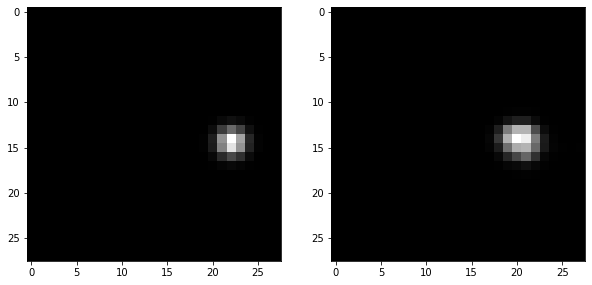

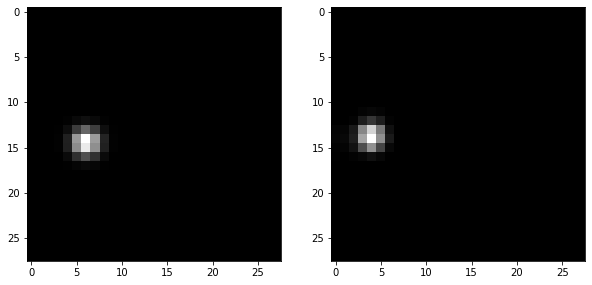

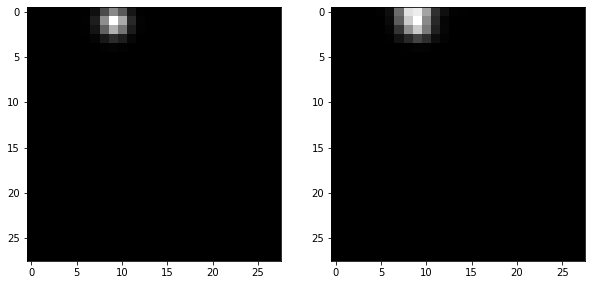

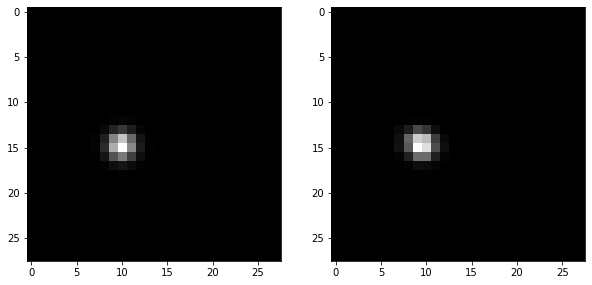

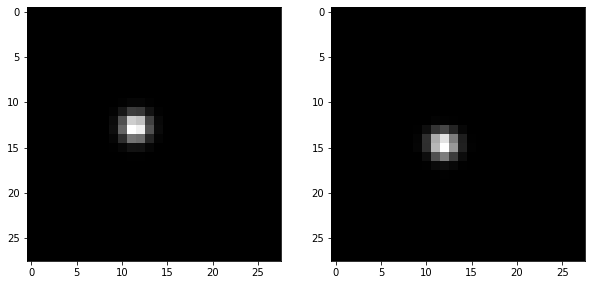

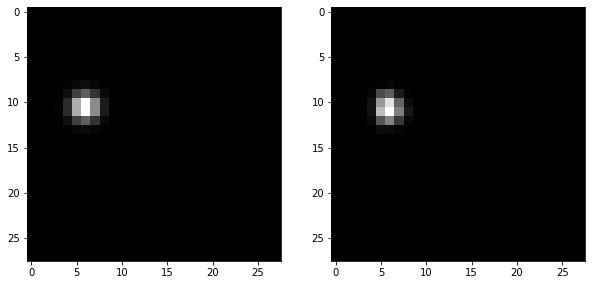

In [11]:
images = [image for image in samples]
for i, index in enumerate([0, len(images)//5, len(images)//4, len(images)//2, 3*len(images)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pred_image = model(torch.tensor(images[index]).float().unsqueeze(0))
    pred_image = pred_image.detach().numpy()
    # pred_position = pred_position.detach().numpy()

    # print(f"Position predicted : {pred_position[0,:2]} | True position : {samples[index][1][:2]}")
    # print(f"Radius predicted : {pred_position[0,2]} | Radius position : {samples[index][1][2]}")
    ax[0].imshow(np.squeeze(images[index]), cmap='gray')
    ax[1].imshow(pred_image.squeeze(), cmap='gray')
    plt.show()

# Generate the animation of the trajectory

In [42]:
class Ball:
    def __init__(self, x0, r, move_func):
        self.x0 = x0
        self.r = int(np.array(r))
        self.x = np.copy(x0)
        self.t = 0
        self.move_func = move_func

    def reset(self):
        self.x = np.copy(self.x0)
        self.t = 0

    def step(self, dt):
        self.t += dt
        x = np.copy(self.x)
        self.x += dt*self.move_func(self.t, x)
        
        return self.x

    

class Image(Ball):
    def __init__(self, x0, r, move_func, size, border=2, gaussian=True):
        super(Image, self).__init__(x0, r, move_func)
        self.size = size
        self.border = border
        self.image_dim = (size, size, 3)
        self.image = np.zeros(self.image_dim, dtype=np.uint8)
        self.r = r
        self.gaussian = gaussian

        x = self.compute_position_on_image(self.x)
        self.indices_matrix = np.array([[i,j] for i in range(size) for j in range(size)])
    
        if gaussian:
            image = np.zeros((size, size), dtype=np.uint8)
            x = np.random.randint(size, size=(2))
            # compute the density over the image and normalize it
            image = gaussian_density(self.indices_matrix, x, r).numpy().copy()
            self.image = image.reshape(size, size, 1)

        else:
            self.image = cv2.circle(np.zeros(self.image_dim, dtype=np.uint8), (x[0], x[1]), self.r, (255, 255, 255), -1)


    def compute_position_on_image(self, x):
        x = (x - self.border[0])/(self.border[1] - self.border[0])
        x = x*(self.size-1)
        x = x.astype(np.uint8)
        x = np.clip(x, 0, self.size-1)

        return x

    def compute_position_on_image_float(self, x):
        x = (x - self.border[0])/(self.border[1] - self.border[0])
        x = x*(self.size-1)
        x = x.astype(np.float32)
        x = np.clip(x, 0, self.size-1)

        return x

    def update_image(self):
        x = self.compute_position_on_image_float(self.x)
        if self.gaussian:
            image = np.zeros((self.size, self.size), dtype=np.uint8)
            # x = np.random.randint(self.size, size=(2))
            # compute the density over the image and normalize it
            image = gaussian_density(self.indices_matrix, x, self.r).numpy().copy()
            self.image = image.reshape(self.size, self.size, 1)

        else:
            self.image = cv2.circle(np.zeros(self.image_dim, dtype=np.uint8), (x[0], x[1]), self.r, (255, 255, 255), -1)


    def display(self):
        self.update_image()
        plt.imshow(self.image)
        plt.show()

    def forward(self, dt):
        x = self.step(dt)
        self.update_image()
        return x

    def animate(self, dt, frames=100, interval=20, repeat_delay=0):
        
        self.reset()
        fig = plt.figure()
        ax = plt.axes(xlim=(0, self.size), ylim=(0, self.size))
        ax.imshow(self.image)

        def init():
            self.reset()
            ax.imshow(self.image)
            return ax,

        def update(i):
            self.forward(dt)
            ax.imshow(self.image)
            return ax,
            

        anim = FuncAnimation(fig, update, init_func=init, frames=trange(0,frames), interval=interval, repeat_delay=repeat_delay)
        # plt.show()
        anim.save('images/AE/ball_animation.gif', writer='pillow')
        plt.close()

    def generate_samples(self, dt, frames=100, conv=False):
        self.reset()


        if frames > 0:
            if conv:
                samples = np.zeros((frames, 1, self.image_dim[0], self.image_dim[1]))

            else:
                samples = np.zeros((frames, self.image_dim[0], self.image_dim[1]))

            for i in range(frames):
                self.forward(dt)
                if conv:
                    samples[i, 0] = self.image[:,:,0]

                else:
                    samples[i] = self.image[:,:,0]

            return samples

        else:
            samples = []
            current_x = np.copy(self.x)
            while True:
                x = self.forward(dt)
                if np.linalg.norm(x - current_x) < 1E-2*dt:
                    break
                current_x = np.copy(x)
                if conv: 
                    samples.append(np.expand_dims(self.image[:,:,0], axis=0))
                else:
                    samples.append(self.image[:,:,0])
                
            return np.array(samples)
    
    def generate_trajectory_positions(self, dt, frames=100):
        self.reset()

        if frames > 0:
            
            samples = np.zeros((frames, 2))

            for i in range(frames):
                x = self.forward(dt)
                x = self.compute_position_on_image_float(x)
                samples[i] = x

            return samples

        else:
            samples = []
            current_x = np.copy(self.x)
            while True:
                x = self.forward(dt)
                x = self.compute_position_on_image_float(x)
                if np.linalg.norm(x - current_x) < 1E-2*dt:
                    break
                current_x = np.copy(x)
                samples.append(x)
                
            return np.array(samples)

def move_fun_circle(t, x, w=1, exp_decay=1.):
    return np.exp(-exp_decay*t)*np.array([-w*np.sin(w*t), w*np.cos(w*t)], dtype=np.float32)    


In [48]:
N = 10000
dt = 0.001
image_generator = Image(np.array([1., 1.], dtype=np.float64), 1., lambda t,x: move_fun_circle(t,x, w=3, exp_decay=0.5), size=28, border=(-2., 3.), gaussian=True)
images = image_generator.generate_samples(dt, frames=N, conv=True)
# Normalize samples
images = images
positions = image_generator.generate_trajectory_positions(dt, frames=N)

print(images.shape)

(10000, 1, 28, 28)


In [44]:
print(images.max())

0.15915322303771973


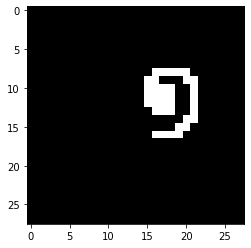

In [45]:
points = np.array([ np.unravel_index(np.argmax(image[0]), image[0].shape) for image in images])
points
screen = np.zeros((28, 28), dtype=np.float64)
for point in points:
    screen[point[0], point[1]] = 1.

plt.imshow(screen, cmap='gray')
plt.show()

In [49]:
print(positions.shape)
np.save("images/AE_ODE/encoded_reconstruction/centered_trues_positions_fast_spiral.npy", positions)
np.save("images/AE_ODE/encoded_reconstruction/centered_trues_images_fast_spiral.npy", images)

(10000, 2)


In [242]:
# image.animate(0.01, frames=150, interval=10, repeat_delay=0)

In [243]:
def generate_animation_model(model, samples, frames=100, interval=20, repeat_delay=0):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, samples.shape[2]), ylim=(0, samples.shape[2]))
    ax.imshow(np.squeeze(samples[0]), cmap='gray')
    model.eval()
    
    def init():
        ax.imshow(np.squeeze(samples[0]), cmap='gray')
        return ax,

    def update(i):
        image = torch.tensor(samples[i]).unsqueeze(0).float()
        ax.imshow(np.array(model(image).detach().squeeze()), cmap='gray')
        return ax,
        

    anim = FuncAnimation(fig, update, init_func=init, frames=trange(0,frames), interval=interval, repeat_delay=repeat_delay)
    # plt.show()
    anim.save('images/AE/ball_animation_reconstructed.gif', writer='pillow')
    plt.close()

In [244]:
# generate_animation_model(model, samples, frames=150, interval=1, repeat_delay=0)

In [50]:
model = ConvAE(height=28, width=28, latent_dim=2)
model.load_state_dict(torch.load("models/AE/conv_custom_2_gaussian_r_1_custom_loss_alpha_0_0.pt"))

Number of parameters in the model: 220387


<All keys matched successfully>

In [51]:
input_samples = torch.tensor(images).float()
encoded_samples = model.encoder_linear(model.encode(input_samples)).detach().numpy()
np.save('images/AE_ODE/encoded_reconstruction/centered_encoded_samples_fast_spiral_2.npy', encoded_samples)


# Watch the trajectory in the latent space using TSNE

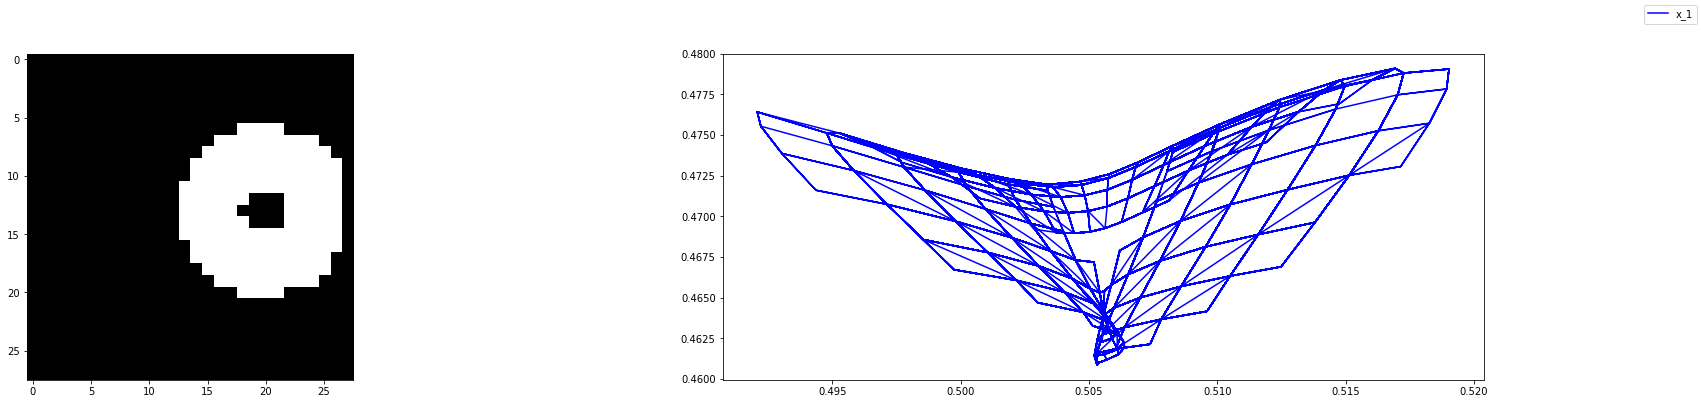

In [245]:
def plot_latent(model, images, title):
    
    input_samples = torch.tensor(images).float()
    encoded_samples = model.encoder_linear(model.encode(input_samples)).detach().numpy()
    # tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    # tsne_results = tsne.fit_transform(encoded_samples)
    tsne_results = encoded_samples
    fig, ax = plt.subplots(1, 2, figsize=(30, 6))
    # ax[1].plot(range(len(tsne_results)), tsne_results[:,0], 'blue', label='x_1')
    # ax[2].plot(range(len(tsne_results)), tsne_results[:,1], 'red', label='x_2')
    ax[1].plot(tsne_results[:,0], tsne_results[:,1], 'blue', label='x_1')

    
    points = np.array([ np.unravel_index(np.argmax(image[0]), image[0].shape) for image in images])
    screen = np.zeros((28, 28), dtype=np.float64)
    for point in points:
        screen[point[0], point[1]] = 1.

    ax[0].imshow(screen, cmap='gray')
    fig.legend()
    plt.show()

plot_latent(model, images, title="Latent space visualization of a small evolution ")

# Try to draw an interactive plot using bokeh library

In [205]:
input_samples = torch.tensor(images).float()
encoded_samples = model.encoder_linear(model.encode(input_samples)).detach().numpy()
times = np.arange(0, encoded_samples.shape[0]*dt, dt)
print(encoded_samples.shape, times.shape)

(750, 2) (750,)


In [203]:
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner, 
from bokeh.plotting import figure, show

# prepare some data
t = times
y = encoded_samples[:,0]

# create plot with circle glyphs
p = figure(x_range=(1, 9), width=500, height=250)
p.plot(t, y, color='navy', line_width=2)
# Make the plot interactive by moving the position of the red circle
# along the trajectory over time
r = p.circle(x=t[0], y=y[0], size=10, fill_color="red")

r.data_source.data["x"] = t
r.data_source.data["y"] = y

# set up textarea (div)
div = Div(
    text="""
          <p>Select the circle's size using this control element:</p>
          """,
    width=200,
    height=30,
)

# set up RangeSlider
range_slider = RangeSlider(
    title="Adjust  range",
    start=0,
    end=len(t)*dt,
    step=dt,
)

range_slider.js_link("value", r.data_source.data["t"], "time")

# create layout
layout = layout(
    [
        [range_slider],
        [p],
    ]
)

# show result
show(layout)

# Back to ODE

In [29]:
class ODEfunc(nn.Module):
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.dim = dim
        self.mid_dim = 40
        self.seq = nn.Sequential(
            nn.Linear(dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, dim),
            # nn.Tanh()
        )

    def forward(self, t, x):
        return self.seq(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x, t):
        # integration_time = self.integration_time.type_as(x)
        
        out = odeint_adjoint(self.odefunc, x, t.reshape(-1), rtol=1e-4, atol=1e-4)
        return out


class ODEnetSimple(nn.Module):
    def __init__(self, out_dim):
        super(ODEnetSimple, self).__init__()

        odefunc = ODEfunc(dim=out_dim)
        
        self.ode_block = ODEBlock(odefunc)  #Use ODE Block
        # self.norm2 = nn.BatchNorm1d(mid_dim)
        # self.fc2 = nn.Linear(mid_dim, out_dim)

        # count the number of parameters
        print("Number of parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, x, t):
        # print(x.shape)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        out = self.ode_block(x, torch.flatten(t))
        # print(out.shape)
        # print(out)
        # out = self.norm2(out)
        # out = self.fc2(out)

        return out

class LatentODE(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(LatentODE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.ode_net = ODEnetSimple(out_dim=self.latent_dim)
        self.ae = ConvAE(latent_dim=self.latent_dim, height=self.input_dim, width=self.input_dim)

    def forward(self, x, t):
        latent_x = self.ae.encode(x)
        # print(latent_x.shape)
        latent_x = self.ae.encoder_linear(latent_x)
        # print(latent_x.shape)
        latent_t = self.ode_net(latent_x, t)[-1]
        # print(latent_t.shape)
        out = self.ae.decoder_linear(latent_t)
        out = out.view(-1, 128, 3, 3)
        # print(out.shape)
        out = self.ae.decode(out)
        # print(out.shape)
        return out
        

latent_model = LatentODE(latent_dim=10, input_dim=28)
latent_model.ae.load_state_dict(torch.load('models/AE/custom_10_conv_ae_small_ball.pt'))

Number of parameters: 2490
Number of parameters in the model: 238827


<All keys matched successfully>

In [96]:
input_img = torch.zeros(15, 1, 28, 28)
times = torch.linspace(0, 1, 20)
latent_model(input_img, times).shape

torch.Size([15, 1, 28, 28])

In [30]:
import torch.nn.functional as F
from tqdm.notebook import trange

class batchGetter:
    def __init__(self, batch_time, n_samples, total_length, dt, images, N_train, noise=-1):
        self.times = torch.linspace(0., total_length*dt, total_length).float()
        self.true_images = torch.tensor(images).float()
        self.noise = noise

        # if noise > 0 and noise < 1:
        #     # adding gaussian noise to the true positions
        #     self.true_positions = self.true_positions + torch.normal(0, noise, size=self.true_positions.shape)
        #     self.true_positions = self.true_positions.float()

        self.train_times = self.times[:N_train]
        self.test_times = self.times[N_train:]
        self.train_images = self.true_images[:N_train]
        self.test_images = self.true_images[N_train:]
        self.n_samples = n_samples
        self.batch_time = batch_time
        self.N_train = N_train
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        s = torch.from_numpy(np.random.choice(np.arange(self.N_train - self.batch_time, dtype=np.int64), self.n_samples, replace=False))
        batch_y0 = self.train_images[s]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_images[s + i] for i in range(self.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y

# train our ODENet on the Ball motion

def train(model, optimizer, device, epochs, getter, display=100):
    
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    for i in iterator:
        # get a random time sample
        batch_init_images, batch_times, batch_true_images = getter.get_batch()
        # compute the output of the model
        out = model(batch_init_images, batch_times.to(device))
        # compute the loss
        # print(out.shape)
        # print(batch_true_images.shape)
        loss = F.mse_loss(out.view(getter.n_samples,-1), batch_true_images[-1].view(getter.n_samples,-1).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.6f}')

        if i % display == 0:
           plot_latent(model.ae, getter.train_images)
        
    return None


# def display_results(model, ball, getter, final_time, dt):

#     with torch.no_grad():
#         times = torch.linspace(0., final_time*dt, final_time, dtype=torch.float64).float()
#         predicted_output = model(getter.train_positions[0].unsqueeze(0).to(device), times.to(device))
#         # display in orange the predicted position and in blue the true position of the training set
        
#         ball.reset()
#         positions = get_positions(ball, final_time, dt)
        
#         plt.plot(predicted_output[:,-1,0].cpu().detach().numpy(), 
#                 predicted_output[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted")

#         # if getter.noise > 0 and getter.noise < 1:
#         #     plt.scatter(getter.train_positions[:,0].cpu().detach().numpy(), 
#         #         getter.train_positions[:,1].cpu().detach().numpy(), s=1, c='b', label="True train")

#         #     plt.scatter(positions[N_train:,0].cpu().detach().numpy(), 
#         #         positions[N_train:,1].cpu().detach().numpy(), s=1, c='cyan', label="True test")
        
#         # else:
#         plt.plot(getter.train_positions[:,0].cpu().detach().numpy(), 
#             getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train")

#         plt.plot(positions[getter.N_train:,0], 
#                 positions[getter.N_train:,1], 'cyan', label="True test")

#         plt.legend()
#         plt.show()

#         # print the X axis over the time
#         plt.plot(times, positions[:,0], 'r', label="True X")
#         plt.plot(times, predicted_output[:,-1,0].cpu().detach().numpy(), 'orange', label="Predicted X")
#         plt.plot(getter.train_times, getter.train_positions[:,0].cpu().detach().numpy(), 'b', label="True train X")
#         plt.legend()
#         plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_21710/2206630048.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_samples = torch.tensor(images).float()
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.000s...
[t-SNE] Computed neighbors for 700 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.216377
[t-SNE] KL divergence after 500 iterations: 0.324589
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


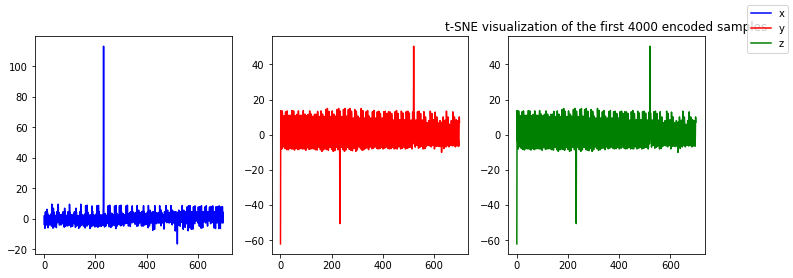

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_21710/2206630048.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_samples = torch.tensor(images).float()
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.000s...
[t-SNE] Computed neighbors for 700 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.781143
[t-SNE] KL divergence after 500 iterations: 1.207958
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


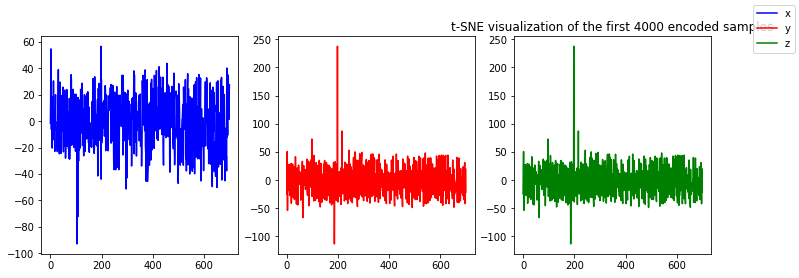

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_21710/2206630048.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_samples = torch.tensor(images).float()
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.000s...
[t-SNE] Computed neighbors for 700 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 128.977722
[t-SNE] KL divergence after 500 iterations: 2.357289
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


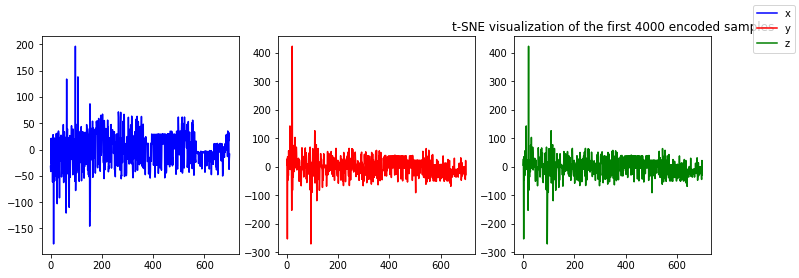

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_21710/2206630048.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_samples = torch.tensor(images).float()
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.000s...
[t-SNE] Computed neighbors for 700 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 127.224449
[t-SNE] KL divergence after 500 iterations: 2.279077
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


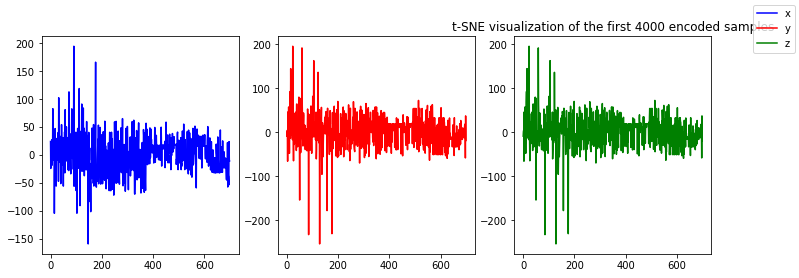

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_21710/2206630048.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_samples = torch.tensor(images).float()
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.000s...
[t-SNE] Computed neighbors for 700 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 138.887482
[t-SNE] KL divergence after 500 iterations: 2.492908
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


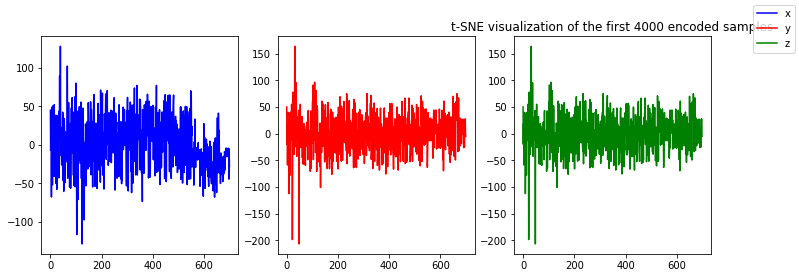

In [98]:
epochs = 100
n_samples = 100
batch_time = 200


ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=10, exp_decay=1.))
# positions = get_positions(ball, N, dt)
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, images=images, N_train=700, noise=-1)
optimizer = torch.optim.Adam(latent_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(latent_model, optimizer, device, epochs, getter, display=20)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_21710/4277269579.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(samples[i]).unsqueeze(0).float()


IndexError: index 1 is out of bounds for dimension 0 with size 1

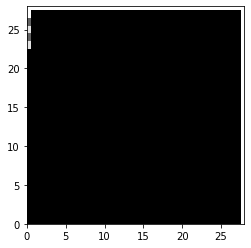

In [106]:
def generate_animation(samples, frames=100, interval=20, repeat_delay=0):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, samples.shape[2]), ylim=(0, samples.shape[2]))
    ax.imshow(np.squeeze(samples[0]), cmap='gray')
    model.eval()
    
    def init():
        ax.imshow(np.squeeze(samples[0]), cmap='gray')
        return ax,

    def update(i):
        image = torch.tensor(samples[i]).unsqueeze(0).float()
        ax.imshow(np.array(image).squeeze(), cmap='gray')
        return ax,
        

    anim = FuncAnimation(fig, update, init_func=init, frames=trange(0,frames), interval=interval, repeat_delay=repeat_delay)
    # plt.show()
    anim.save('images/AE/ball_animation_reconstructed_ODE.gif', writer='pillow')
    plt.close()

generate_animation(predictions, frames=100, interval=1, repeat_delay=0)

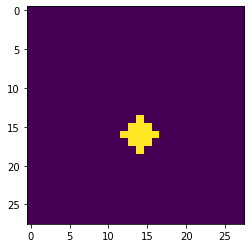

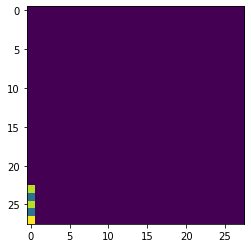

In [101]:
plt.imshow(getter.train_images[0][0])
plt.show()
plt.imshow(predictions[0][0].cpu().detach().numpy())
plt.show()